In [ ]:
import pickle
import pandas as pd
from collections import defaultdict, OrderedDict, Counter
import time
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import re
import os
import scipy
import urllib

import sys
sys.path.append("/home/yara/Documents/PseudoFind")
from PseudoFind.pangenome_cmds import *


%matplotlib inline

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import random

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_validate, cross_val_predict,  GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# pan genomics

In [ ]:
from machine_learning_pipeline import *
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [ ]:
directory = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus'
FTSA = pd.read_csv('%s/FT_LRI.csv'%(directory))
pangenome_matrix = np.matrix(pd.read_csv('%s/pangenome/pangenome_matrix.csv'%(directory)).T)

In [ ]:
#a hold-out dataset
data_FS, data_holdout, labels_FS, labels_holdout = get_holdout_dataset(FTSA, pangenome_matrix, directory, keyword = 'pangenome')
print('The holdout data set was saved')

The holdout data set was saved


In [ ]:
#b feature selection
all_rows_FS = run_feature_selection_part1(data_FS, labels_FS)

In [ ]:
#c train ML models
scores_res = train_ML_models_part1(data_FS, labels_FS, all_rows_FS, directory = directory, keyword = 'pangenome')

In [ ]:
scores_res.sort_values(by = 'brier_score_loss').head(10)

,Accuracy,F-1,FS model,MI,ML model,No. selected features,Overfitting proxy,ROC-AUC score,brier_score_loss,jaccard,precision,recall
27,0.991566,0.987433,LinearSVC - C=1 - random,0.925720,LinearSVC(L-2),165,1.197648,0.991869,0.008434,0.991566,0.982143,0.992780
35,0.987952,0.981949,LinearSVC - C=2 - random,0.898712,LinearSVC(L-2),173,1.197648,0.986454,0.012048,0.987952,0.981949,0.981949
31,0.986747,0.980036,LinearSVC - C=0 - random,0.891168,LinearSVC(L-2),153,1.219512,0.983748,0.013253,0.986747,0.985401,0.974729
13,0.979518,0.969147,LinearSVC - C=0 - random,0.845264,LogisticRegression,153,1.666363,0.975620,0.020482,0.979518,0.974453,0.963899
9,0.979518,0.969479,LinearSVC - C=1 - random,0.845781,LogisticRegression,165,2.247084,0.978323,0.020482,0.979518,0.964286,0.974729
17,0.978313,0.967509,LinearSVC - C=2 - random,0.837887,LogisticRegression,173,1.659017,0.975617,0.021687,0.978313,0.967509,0.967509
29,0.975904,0.964029,LogisticRegression - C=2 - random,0.824292,LinearSVC(L-2),167,1.212166,0.973809,0.024096,0.975904,0.960573,0.967509
14,0.971084,0.956679,LogisticRegression - C=1 - random,0.797101,LogisticRegression,154,2.811424,0.967489,0.028916,0.971084,0.956679,0.956679
11,0.971084,0.956679,LogisticRegression - C=2 - random,0.797101,LogisticRegression,167,2.856665,0.967489,0.028916,0.971084,0.956679,0.956679
32,0.969880,0.954792,LogisticRegression - C=1 - random,0.790532,LinearSVC(L-2),154,3.592943,0.965684,0.030120,0.969880,0.956522,0.953069


In [ ]:
#d choose best ML pipeline, run bootstrap and select minimum no. features
bootstrap_rows = run_feature_selection_part2(data_FS, labels_FS, C = 1, directory = directory, keyword = 'pangenome')

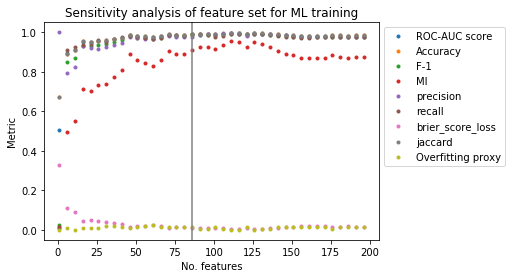

In [ ]:
#e assess performance

bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
scores_FS_df = assess_performance(data_FS,labels_FS, bootstrap_res, no_features = 200, directory = directory, keyword = 'pangenome')

mi_cutoff = 0.91 # to change here according to the plot!

sorted_features = abs(bootstrap_res).sum(axis = 1).sort_values(ascending = False)
selected_features_final = sorted_features[:min(scores_FS_df.loc[scores_FS_df['MI'] > mi_cutoff]['No. selected features'])].index
selected_features_final = pd.DataFrame(bootstrap_res.sum(axis = 1).loc[selected_features_final], columns = ['score'])
selected_features_final.to_csv('%s/machine_learning/selected_features_final_trial_2_pangenome.csv'%directory)

In [ ]:
selected_features_final.shape

(86, 1)

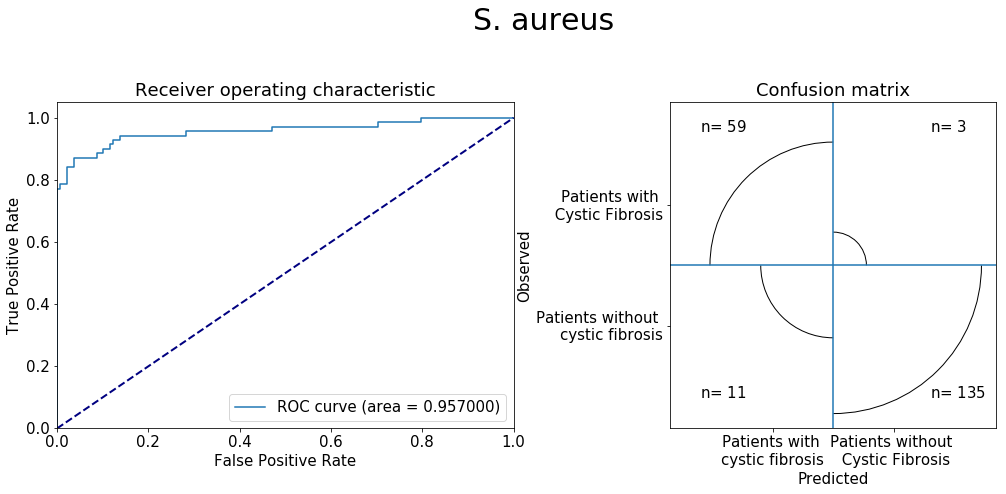

In [ ]:
generate_figures(data_FS, labels_FS, data_holdout, labels_holdout, selected_features_final, 'S. aureus')

# allelomics

In [ ]:
FT_LRI = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv')
directory = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus/'
allele_matrix = scipy.sparse.load_npz('%s/allele_matrix/allele_matrix.npz'%directory).todense().T

In [ ]:
allele_matrix.shape, allele_matrix.shape

((1038, 87263), (1038, 87263))

#a hold-out dataset

In [ ]:
data_FS, data_holdout, labels_FS, labels_holdout = get_holdout_dataset(FT_LRI, allele_matrix, directory)

#b feature selection

In [ ]:
all_rows_FS = run_feature_selection_part1(data_FS, labels_FS)

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#c train ML models

In [ ]:
scores_res = train_ML_models_part1(data_FS, labels_FS, all_rows_FS, directory = directory)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='a

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='a

In [ ]:
scores_res.head(1)

,Accuracy,F-1,FS model,MI,ML model,No. selected features,Overfitting proxy,ROC-AUC score,brier_score_loss,jaccard,precision,recall
43,1.0,1.0,LinearSVC - C=1 - random,1.0,LinearSVC(L-2),152,0.0,1.0,0.0,1.0,1.0,1.0


#d choose best ML pipeline, run bootstrap and select minimum no. features

In [ ]:
bootstrap_rows = run_feature_selection_part2(data_FS, labels_FS, directory = directory)





  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:49<1:22:18, 49.88s/it]



  2%|▏         | 2/100 [01:36<1:19:41, 48.79s/it]



  3%|▎         | 3/100 [02:25<1:19:21, 49.09s/it]



  4%|▍         | 4/100 [03:12<1:17:34, 48.49s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






  5%|▌         | 5/100 [04:03<1:17:35, 49.00s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






  6%|▌         | 6/100 [04:52<1:16:44, 48.98s/it]



  7%|▋         | 7/100 [05:40<1:15:47, 48.89s/it]



  8%|▊         | 8/100 [06:30<1:15:11, 49.03s/it]



  9%|▉         | 9/100 [07:23<1:16:27, 50.41s/it]



 10%|█         | 10/100 [08:13<1:15:17, 50.20s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 11%|█         | 11/100 [09:03<1:14:21, 50.13s/it]



 12%|█▏        | 12/100 [09:53<1:13:25, 50.06s/it]



 13%|█▎        | 13/100 [10:45<1:13:28, 50.67s/it]



 14%|█▍        | 14/100 [11:34<1:11:45, 50.07s/it]



 15%|█▌        | 15/100 [12:25<1:11:17, 50.33s/it]



 16%|█▌        | 16/100 [13:15<1:10:28, 50.34s/it]



 17%|█▋        | 17/100 [14:02<1:08:10, 49.28s/it]



 18%|█▊        | 18/100 [14:47<1:05:48, 48.15s/it]



 19%|█▉        | 19/100 [15:38<1:06:01, 48.91s/it]



 20%|██        | 20/100 [16:25<1:04:39, 48.49s/it]



 21%|██        | 21/100 [17:15<1:04:20, 48.86s/it]



 22%|██▏       | 22/100 [18:00<1:02:01, 47.71s/it]



 23%|██▎       | 23/100 [18:52<1:02:49, 48.96s/it]



 24%|██▍       | 24/100 [19:42<1:02:24, 49.26s/it]



 25%|██▌       | 25/100 [20:29<1:00:38, 48.52s/it]



 26%|██▌       | 26/100 [21:15<58:58, 47.82s/it]  



 27%|██▋       | 27/100 [22:03<58:24, 48.00s/it]



 28%|██▊       | 28/100 [22:46<55:47, 46.49s/it]



 29%|██▉       | 29/100 [23:

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 30%|███       | 30/100 [24:23<55:19, 47.42s/it]



 31%|███       | 31/100 [25:08<53:51, 46.84s/it]



 32%|███▏      | 32/100 [25:57<53:45, 47.44s/it]



 33%|███▎      | 33/100 [26:45<53:17, 47.72s/it]



 34%|███▍      | 34/100 [27:31<51:38, 46.95s/it]



 35%|███▌      | 35/100 [28:20<51:38, 47.67s/it]



 36%|███▌      | 36/100 [29:06<50:16, 47.13s/it]



 37%|███▋      | 37/100 [29:54<49:53, 47.51s/it]



 38%|███▊      | 38/100 [30:46<50:33, 48.93s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 39%|███▉      | 39/100 [31:35<49:44, 48.93s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 40%|████      | 40/100 [32:29<50:12, 50.21s/it]



 41%|████      | 41/100 [33:17<48:52, 49.70s/it]



 42%|████▏     | 42/100 [34:04<47:14, 48.87s/it]



 43%|████▎     | 43/100 [34:48<45:06, 47.49s/it]



 44%|████▍     | 44/100 [35:40<45:34, 48.83s/it]



 45%|████▌     | 45/100 [36:32<45:38, 49.79s/it]



 46%|████▌     | 46/100 [37:16<43:18, 48.11s/it]



 47%|████▋     | 47/100 [38:03<42:12, 47.77s/it]



 48%|████▊     | 48/100 [38:48<40:33, 46.81s/it]



 49%|████▉     | 49/100 [39:38<40:39, 47.83s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 50%|█████     | 50/100 [40:26<39:45, 47.71s/it]



 51%|█████     | 51/100 [41:15<39:27, 48.32s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 52%|█████▏    | 52/100 [42:02<38:14, 47.81s/it]



 53%|█████▎    | 53/100 [42:46<36:29, 46.58s/it]



 54%|█████▍    | 54/100 [43:36<36:29, 47.60s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 55%|█████▌    | 55/100 [44:29<36:54, 49.20s/it]



 56%|█████▌    | 56/100 [45:24<37:22, 50.96s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 57%|█████▋    | 57/100 [46:12<35:55, 50.14s/it]



 58%|█████▊    | 58/100 [47:01<34:48, 49.72s/it]



 59%|█████▉    | 59/100 [47:46<33:01, 48.33s/it]



 60%|██████    | 60/100 [48:28<31:04, 46.60s/it]



 61%|██████    | 61/100 [49:22<31:40, 48.72s/it]



 62%|██████▏   | 62/100 [50:15<31:37, 49.92s/it]



 63%|██████▎   | 63/100 [51:02<30:14, 49.05s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 64%|██████▍   | 64/100 [51:50<29:12, 48.69s/it]



 65%|██████▌   | 65/100 [52:40<28:45, 49.30s/it]



 66%|██████▌   | 66/100 [53:31<28:10, 49.72s/it]



 67%|██████▋   | 67/100 [54:22<27:37, 50.22s/it]



 68%|██████▊   | 68/100 [55:08<26:06, 48.94s/it]



 69%|██████▉   | 69/100 [56:00<25:40, 49.71s/it]



 70%|███████   | 70/100 [56:50<24:54, 49.83s/it]



 71%|███████   | 71/100 [57:39<23:58, 49.59s/it]



 72%|███████▏  | 72/100 [58:27<22:57, 49.21s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 73%|███████▎  | 73/100 [59:17<22:09, 49.26s/it]



 74%|███████▍  | 74/100 [1:00:02<20:49, 48.05s/it]



 75%|███████▌  | 75/100 [1:00:53<20:25, 49.02s/it]



 76%|███████▌  | 76/100 [1:01:42<19:35, 48.97s/it]



 77%|███████▋  | 77/100 [1:02:32<18:54, 49.34s/it]



 78%|███████▊  | 78/100 [1:03:19<17:49, 48.62s/it]



 79%|███████▉  | 79/100 [1:04:06<16:48, 48.02s/it]



 80%|████████  | 80/100 [1:04:54<15:59, 47.99s/it]



 81%|████████  | 81/100 [1:05:37<14:43, 46.52s/it]



 82%|████████▏ | 82/100 [1:06:23<13:54, 46.36s/it]



 83%|████████▎ | 83/100 [1:07:10<13:13, 46.66s/it]



 84%|████████▍ | 84/100 [1:07:53<12:08, 45.51s/it]



 85%|████████▌ | 85/100 [1:08:38<11:22, 45.50s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 86%|████████▌ | 86/100 [1:09:25<10:41, 45.81s/it]



 87%|████████▋ | 87/100 [1:10:12<10:00, 46.16s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 88%|████████▊ | 88/100 [1:11:05<09:38, 48.19s/it]



 89%|████████▉ | 89/100 [1:11:54<08:54, 48.60s/it]



 90%|█████████ | 90/100 [1:12:45<08:12, 49.25s/it]

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)






 91%|█████████ | 91/100 [1:13:38<07:32, 50.25s/it]



 92%|█████████▏| 92/100 [1:14:25<06:35, 49.41s/it]



 93%|█████████▎| 93/100 [1:15:13<05:43, 49.04s/it]



 94%|█████████▍| 94/100 [1:16:00<04:49, 48.29s/it]



 95%|█████████▌| 95/100 [1:16:46<03:58, 47.74s/it]



 96%|█████████▌| 96/100 [1:17:32<03:08, 47.19s/it]



 97%|█████████▋| 97/100 [1:18:19<02:20, 46.97s/it]



 98%|█████████▊| 98/100 [1:19:02<01:31, 45.85s/it]



 99%|█████████▉| 99/100 [1:19:52<00:47, 47.14s/it]



100%|██████████| 100/100 [1:20:41<00:00, 47.71s/it]



                                                   

Text(0.5, 1.0, 'Count of times a feature is selected in an SVM')

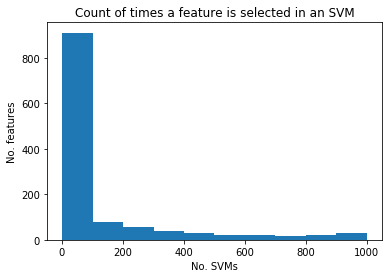

In [ ]:
bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
bootstrap_res_i = bootstrap_res.copy()
bootstrap_res_i[bootstrap_res_i != 0] = 1
plt.hist(bootstrap_res_i.sum(axis = 1))
plt.xlabel('No. SVMs')
plt.ylabel('No. features')
plt.title('Count of times a feature is selected in an SVM')

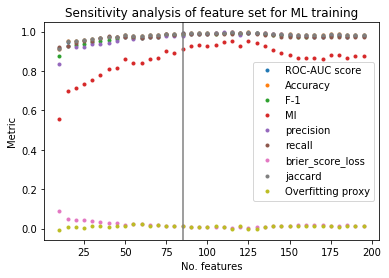

In [ ]:
scores_FS_df = assess_performance(data_FS, labels_FS, bootstrap_res, no_features = 200, directory = directory)

mi_cutoff = 0.91 # to change here according to the plot!
bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
sorted_features = abs(bootstrap_res).sum(axis = 1).sort_values(ascending = False)

selected_features_final = sorted_features[:min(scores_FS_df.loc[scores_FS_df['MI'] > mi_cutoff]['No. selected features'])].index
selected_features_final = pd.DataFrame(bootstrap_res.sum(axis = 1).loc[selected_features_final], columns = ['score'])
selected_features_final.to_csv('%s/selected_features_final_trial_2.csv'%directory)

In [ ]:
# from PseudoFind.functional_annotations import *
# directory = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus/functional_annotation'
# eggnog_file_sa ='%s/selected_features_final.fa.emapper.annotations'%directory
# eggnog_sa = get_eggnog(eggnog_file_sa)
# eggnog_sa

#d plot the results for the best combination

In [ ]:
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix
import matplotlib.patches
import matplotlib.font_manager
import matplotlib

Text(0.5, 1.1, 'S. aureus')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


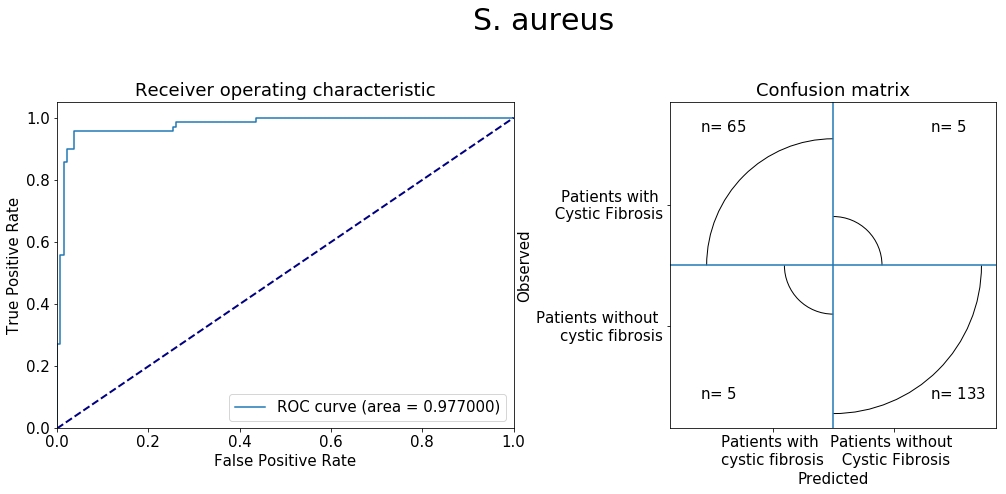

In [ ]:
selected_features = selected_features_final.index
selected_features  = sorted_features[:240].index
clf = LinearSVC(penalty="l2", max_iter = 10000, class_weight = 'balanced')

matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, axes = plt.subplots(1,2, figsize = (18, 6))

lw = 2
y_score = clf.fit(data_FS[:,selected_features], labels_FS).decision_function(data_holdout[:,selected_features])
fpr, tpr, _ = roc_curve(labels_holdout, y_score)
roc_auc_multi = auc(fpr, tpr)
axes[0].plot(fpr, tpr, label='ROC curve (area = %f)'%(round(roc_auc_multi, 3)))
axes[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver operating characteristic')
axes[0].legend(loc="lower right")

predicted = clf.fit(data_FS[:,selected_features], labels_FS).predict(data_holdout[:,selected_features])
conf_m = confusion_matrix(labels_holdout,predicted)

axes[1].axvline(0)
axes[1].axhline(0)
# ax=axes[1].gca()

for count,indices in enumerate([[1,1], [1,0], [0,0], [0,1]]):
    r1 = np.log(conf_m[indices[0]][indices[1]])
    c1 = matplotlib.patches.Arc((0,0), r1, r1, angle = 90, theta1 = 90*(count), theta2 = 90*(count+1))
    axes[1].add_patch(c1)

axes[1].text(-2.2, 2.2, '$\it{n}$= %d'%conf_m[1,1])
axes[1].text(1.6, 2.2, '$\it{n}$= %d'%conf_m[0,1])
axes[1].text(1.6, -2.2, '$\it{n}$= %d'%conf_m[0,0])
axes[1].text(-2.2, -2.2, '$\it{n}$= %d'%conf_m[1,0])

axes[1].axis('scaled')
axes[1].set_xticks([-1, 1])
axes[1].set_xticklabels(['Patients with \ncystic fibrosis','Patients without \n Cystic Fibrosis'])
axes[1].set_xlabel('Predicted')
axes[1].set_yticks([-1, 1])
axes[1].set_yticklabels(['Patients without \ncystic fibrosis','Patients with \n Cystic Fibrosis'])
axes[1].set_ylabel('Observed')
axes[1].set_title('Confusion matrix')

fig.suptitle('S. aureus', y = 1.1, fontsize = 30)

In [ ]:
directory = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus/allele_matrix/'
col_rows = pickle.load(open('%s/col_rows.p'%directory, 'rb'))
input_data = np.load('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/machine_learning/input_data.npz')
train_index = input_data['train_index']
test_index = input_data['test_index']

In [ ]:
FT_LRI = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv', dtype = {'Genome ID':str}).set_index('Genome ID')

In [ ]:
FT = pd.read_csv('/home/yara/Documents/staph_clinical_isolates/data/metadata/PATRIC_FT.csv', dtype = {'Genome ID':str},low_memory=False).fillna('').replace('missing','').set_index('Genome ID')

In [ ]:
holdout_gids = col_rows[0][test_index]

# predicted to be from CF patient, but actually isn;t
FT.loc[set(holdout_gids[predicted == 1]) & set(holdout_gids[labels_holdout == 0])]['Comments']

/home/yara/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


Genome ID
1280.16730     In this study, we performed whole-genome seque...
1280.16420                                                 SAM-2
Sakoulas_15                                                  NaN
1280.16737     In this study, we performed whole-genome seque...
1422223.3                                            MRSA USA100
Name: Comments, dtype: object

In [ ]:
FT.loc[set(holdout_gids[predicted == 0]) & set(holdout_gids[labels_holdout == 1])]['Comments']

Genome ID
1280.12447    Population dynamics of S. aureus in Cystic Fib...
1280.12528    Population dynamics of S. aureus in Cystic Fib...
1280.18623    Staphylococcus aureus is often an early coloni...
1280.18617    Staphylococcus aureus is often an early coloni...
1280.4347     The genetic disorder cystic fibrosis is a life...
1280.12347    Population dynamics of S. aureus in Cystic Fib...
1280.12471    Population dynamics of S. aureus in Cystic Fib...
1280.12438    Population dynamics of S. aureus in Cystic Fib...
Name: Comments, dtype: object

In [ ]:
FT.loc[holdout_gids[predicted != labels_holdout]]['Comments']

/home/yara/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


1280.18623     Staphylococcus aureus is often an early coloni...
1422223.3                                            MRSA USA100
1280.16420                                                 SAM-2
1280.18617     Staphylococcus aureus is often an early coloni...
1280.12438     Population dynamics of S. aureus in Cystic Fib...
1280.12447     Population dynamics of S. aureus in Cystic Fib...
1280.16730     In this study, we performed whole-genome seque...
1280.16737     In this study, we performed whole-genome seque...
1280.12347     Population dynamics of S. aureus in Cystic Fib...
Sakoulas_15                                                  NaN
1280.12528     Population dynamics of S. aureus in Cystic Fib...
1280.4347      The genetic disorder cystic fibrosis is a life...
1280.12471     Population dynamics of S. aureus in Cystic Fib...
Name: Comments, dtype: object